In [81]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
## import & concat out three housing datasets
path = '/Users/andrewma/Desktop/Stat-Notes/data/'
df = pd.concat(map(pd.read_csv, [path + 'texas_counties1.csv', path + 'texas_counties2.csv', path + 'texas_counties3.csv']))

#remove 2 rows of NaN in 'sales','dollar_vol','avg_price','med_price']
df.columns[df.isna().any()].tolist()
df.loc[:, df.isnull().any()]
df = df[-df['sales'].isna()]

In [83]:
## clean up commas & convert strings to float
str_cols = ['sales', 'dollar_vol', 'avg_price', 'med_price', 'total_listings']
df[str_cols] = df[str_cols].replace(',', '', regex=True)
df[str_cols] = df[str_cols].apply(pd.to_numeric, errors='coerce')

In [84]:
## clean dataset & impute missing values 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

#remove 'Unnamed:0' column as it simply is another index for the month
df = df.drop(columns='Unnamed: 0')

#convert date column to datetime format & sort
df['date'] = pd.to_datetime(df['date'])

""" total = df['total_listings'].values.reshape(1, -1)
month = df['month_inventory'].values.reshape(1, -1)

#probabilistic PCA to infer NaN values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(month)
df['month'] = imp_mean.transform(month))

imp_mean.fit(total)
df['total'] = imp_mean.transform(total)) """

" total = df['total_listings'].values.reshape(1, -1)\nmonth = df['month_inventory'].values.reshape(1, -1)\n\n#probabilistic PCA to infer NaN values\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nimp_mean.fit(month)\ndf['month'] = imp_mean.transform(month))\n\nimp_mean.fit(total)\ndf['total'] = imp_mean.transform(total)) "

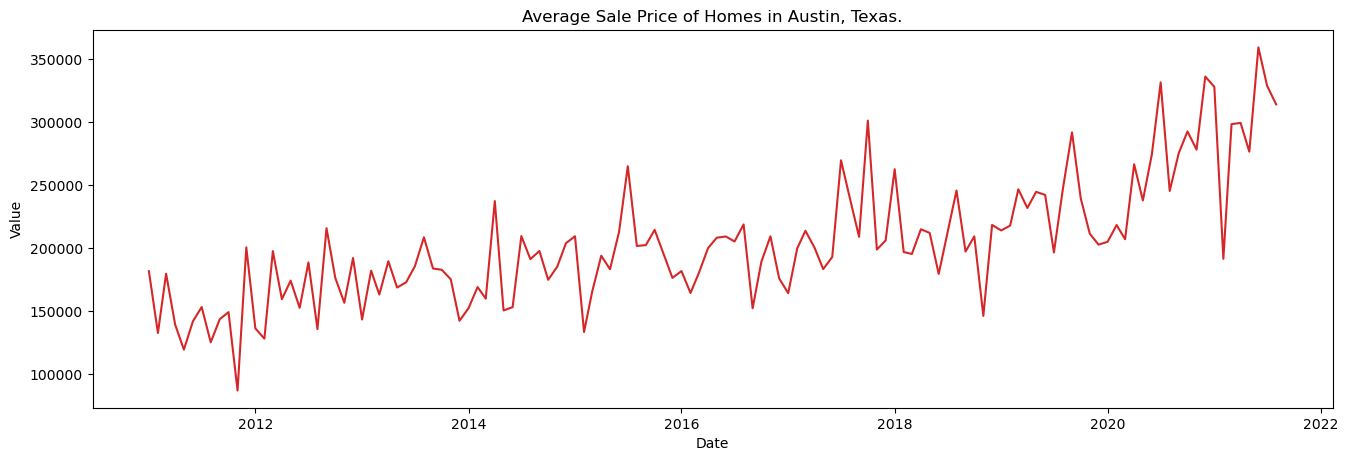

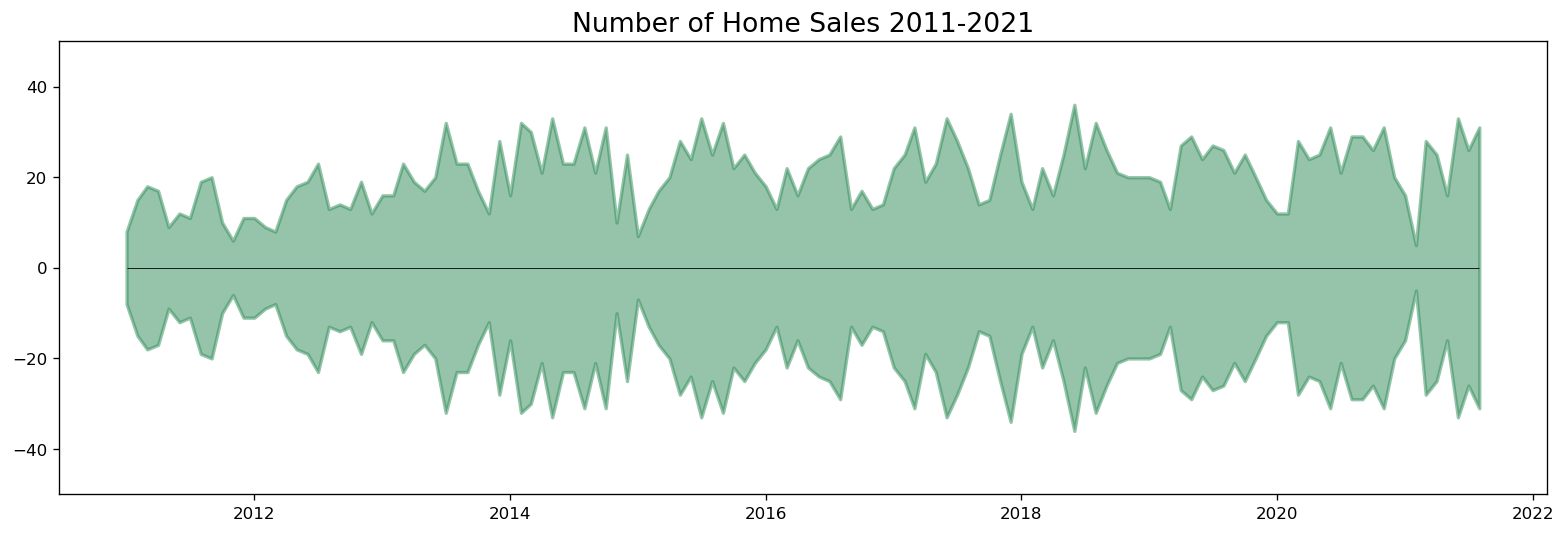

In [134]:
## modeling variances of average home prices
## pull out county consisting of high variance
vvv = df[df['county'] == 'Austin']

## Prepare data
vvv['year'] = [d.year for d in vvv.date]
vvv['month'] = [d.strftime('%b') for d in vvv.date]
years = vvv['year'].unique()

## basic time series plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=vvv.date, y=vvv.avg_price, title='Average Sale Price of Homes in Austin, Texas.') 

## Explore growth of home sales over past decade
x = vvv['date'].values
y1 = vvv['sales'].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-50, 50)
plt.title('Number of Home Sales 2011-2021', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.show()


Additive time series: Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series: Value = Base Level x Trend x Seasonality x Error

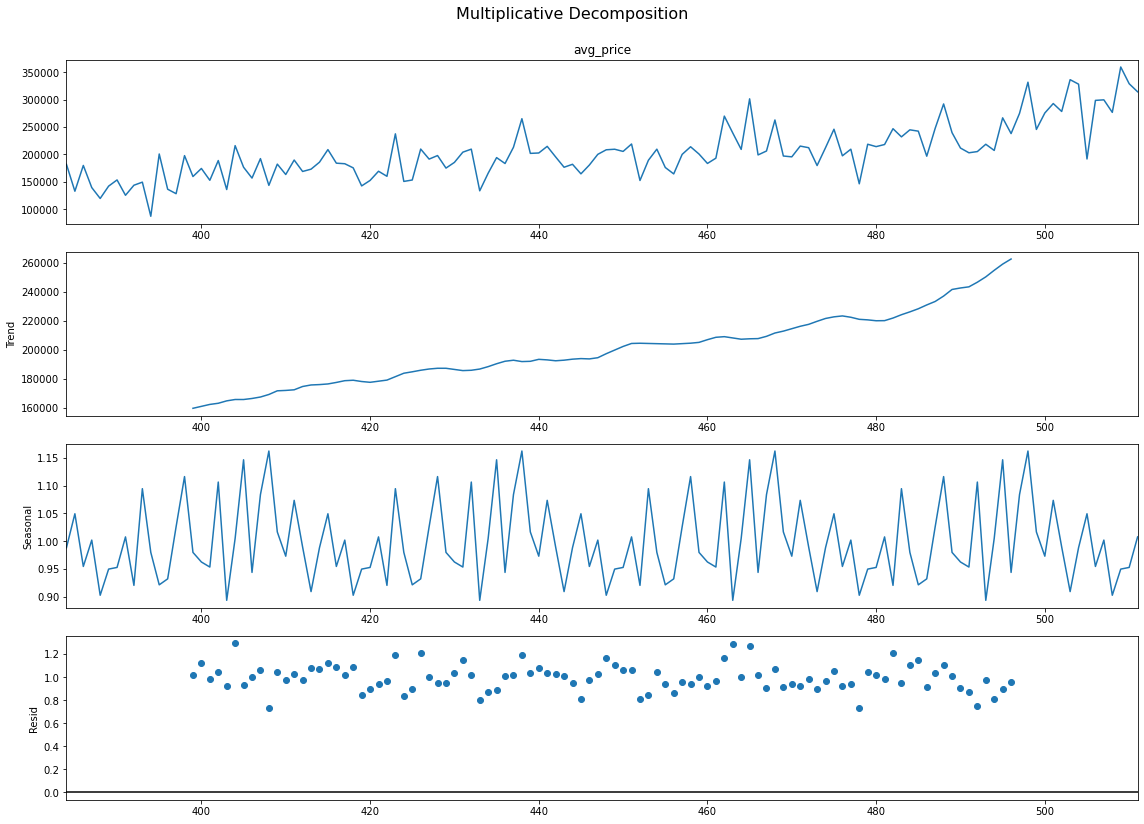

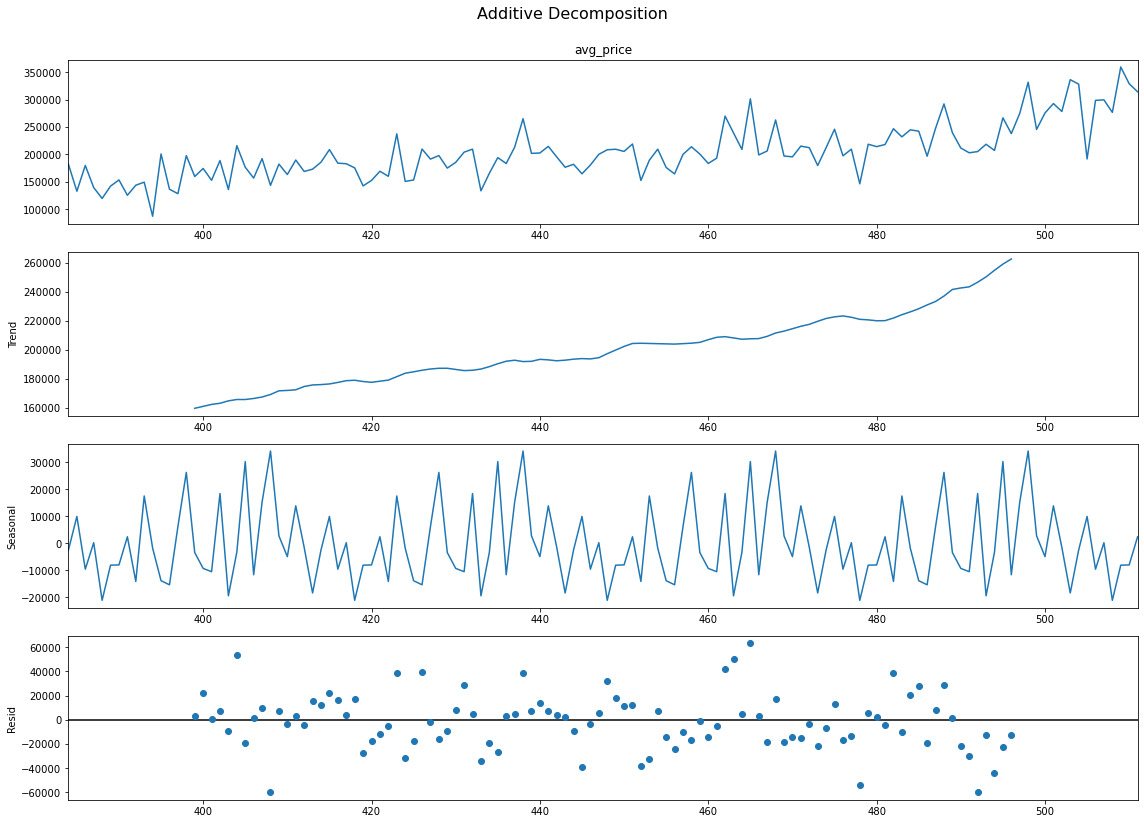

In [135]:
## Decomposition of Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(vvv['avg_price'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(vvv['avg_price'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

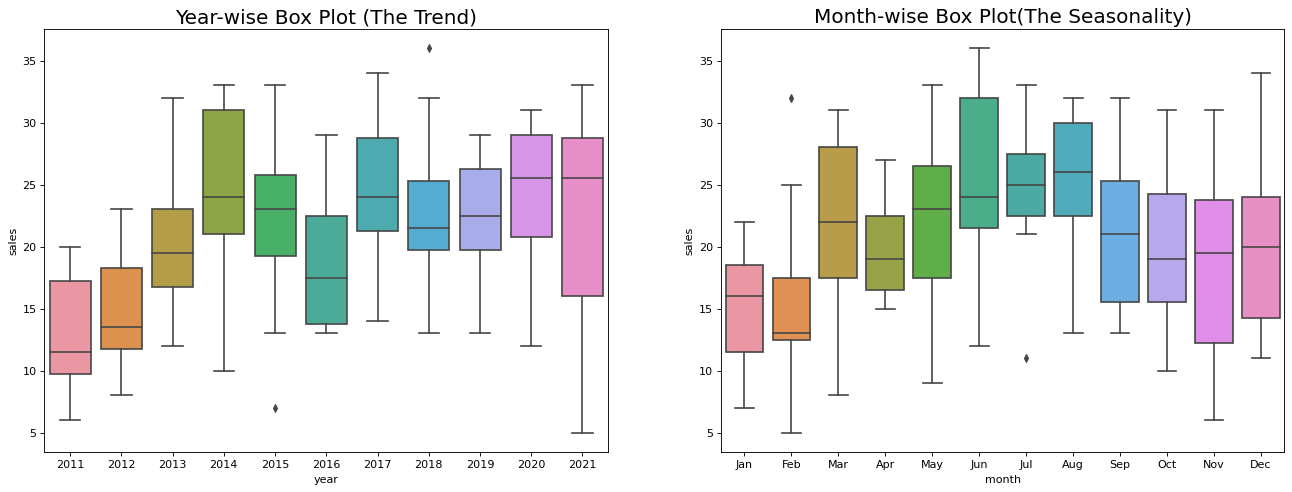

In [107]:
## Boxplots for Seasonality trend 
sns.boxplot(x='year', y= 'sales', data=vvv, ax=axes[0])
sns.boxplot(x='month', y='sales', data=vvv.loc[~vvv.year.isin([1991, 2008]), :])

## plot title & options
axes[0].set_title('Year-wise Box Plot (The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot(The Seasonality)', fontsize=18)
plt.show()

In [138]:
## predefine features & labels
features = ['dollar_vol','avg_price','med_price','total_listings','month_inventory']
target = ['sales']

## normalize data - notice that there are large differences beween integer values which may cause 
## weights of our model to vary wildy
df[target] = np.log(df[target])
df[features] = np.log(df[features])
df.describe().transpose()[['mean', 'std']]

,mean,std
sales,5.062834,1.565226
dollar_vol,17.284101,1.776599
avg_price,12.221268,0.345040
med_price,12.071589,0.338053
total_listings,6.478592,1.345088
month_inventory,1.291162,0.594785
year,2015.840834,3.080623


In [139]:
## split into training & testing for Time series methods
## test = ~20% of data consisting most recent dates, train = all other data
#df.dropna()
df = df.sort_values(by=['date'])
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.2)
train = df.head(4600)
test = df.tail(530)

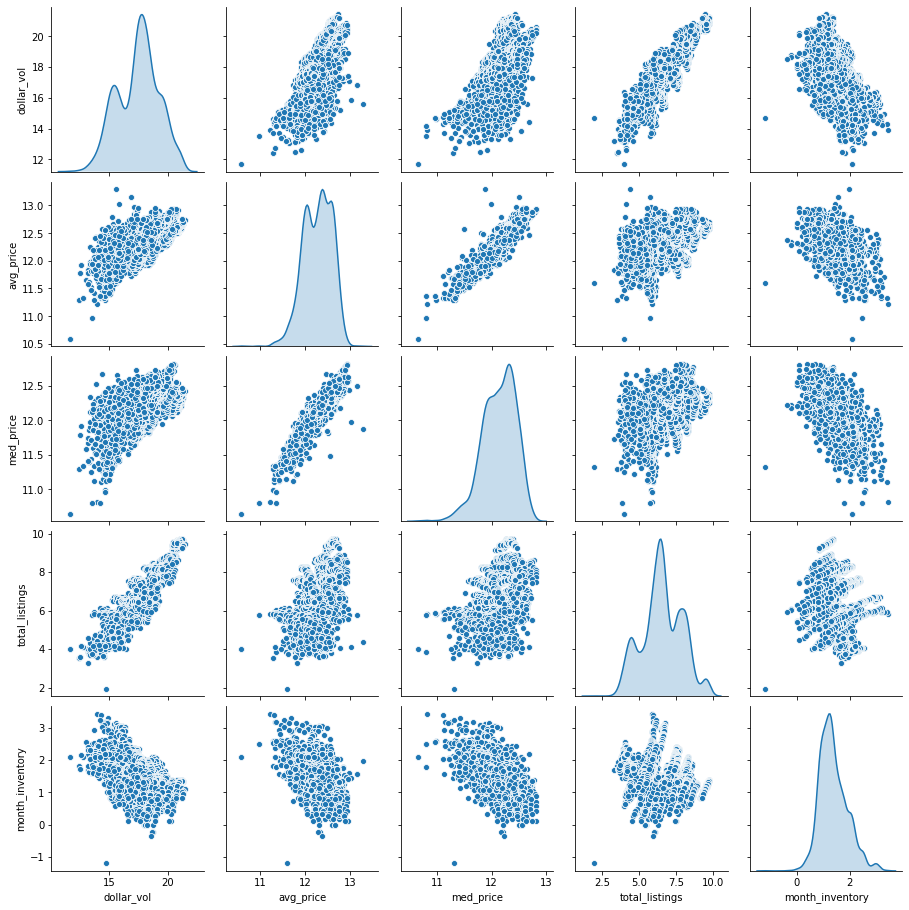

In [152]:
## basic exploratory plots
import seaborn as sns
# Draw Plot
sns.pairplot(train[features], diag_kind = 'kde')

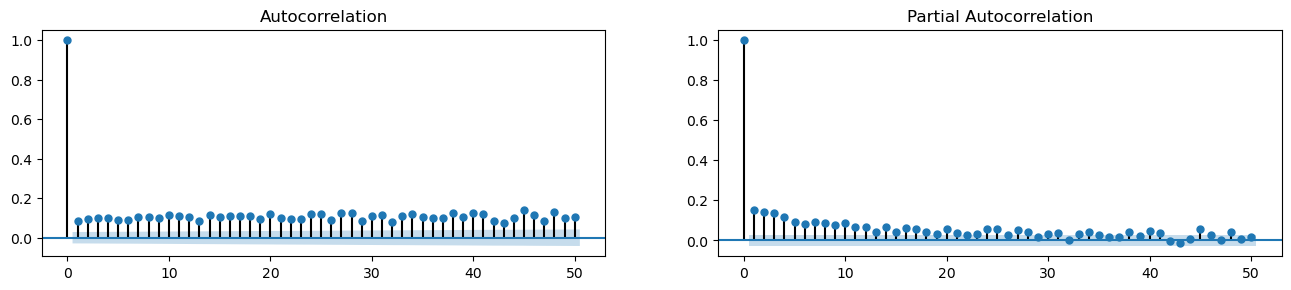

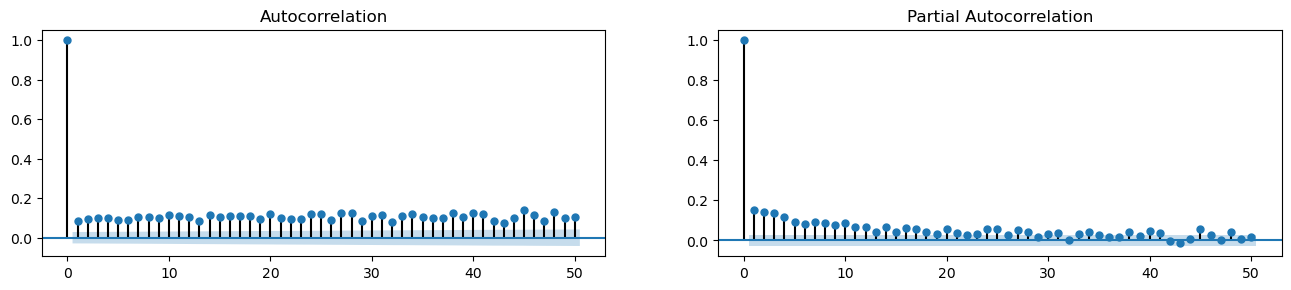

In [141]:
## autocorrelation plots
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train['avg_price'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['avg_price'].tolist(), lags=50, ax=axes[1])

**Rolling Regressions** are one of the simplest models for analysing changing relationships among variables overtime. They use linear regression but allow the data set used to change over time. In most linear regression models, parameters are assumed to be time-invariant and thus should not change overtime. Rolling regressions estimate model parameters using a fixed window of time over the entire data set. A larger sample size, or window, used will result in fewer parameter estimates but use more observations. 

**Recursive Rolling Regression**; A rolling regression with an expanding (rather than moving) window is effectively a recursive least squares model. We start with our desired window size, and add data as we expand outwards; usually capture the whole dataset 

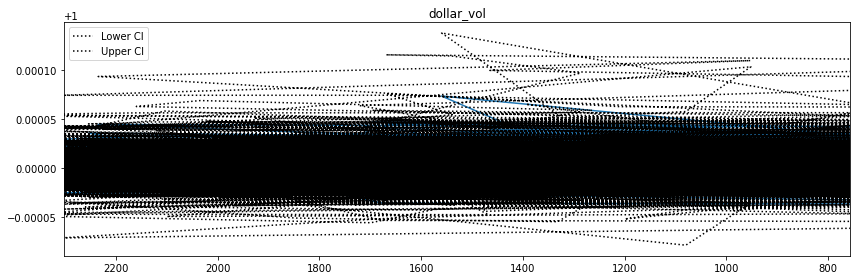

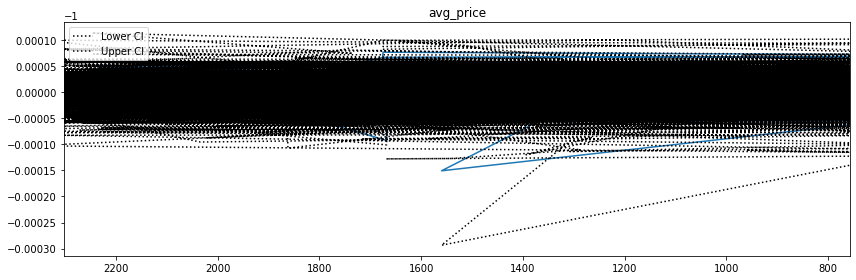

In [150]:
## Rolling regression with differing window sizes
from statsmodels.regression.rolling import RollingOLS
from statsmodels.datasets import longley
import statsmodels.api as sm

## '-1' argument supresses model estimate for intercept
roll_reg = RollingOLS.from_formula('sales ~ dollar_vol + avg_price + med_price + total_listings + month_inventory', 
    window = 12, data = train) 
model = roll_reg.fit()

fig = model.plot_recursive_coefficient(variables=['dollar_vol'], figsize = (12, 4))
fig = model.plot_recursive_coefficient(variables=['avg_price'], figsize = (12, 4))

/Users/andrewma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Text(0.5, 1.0, 'Coefficient value')

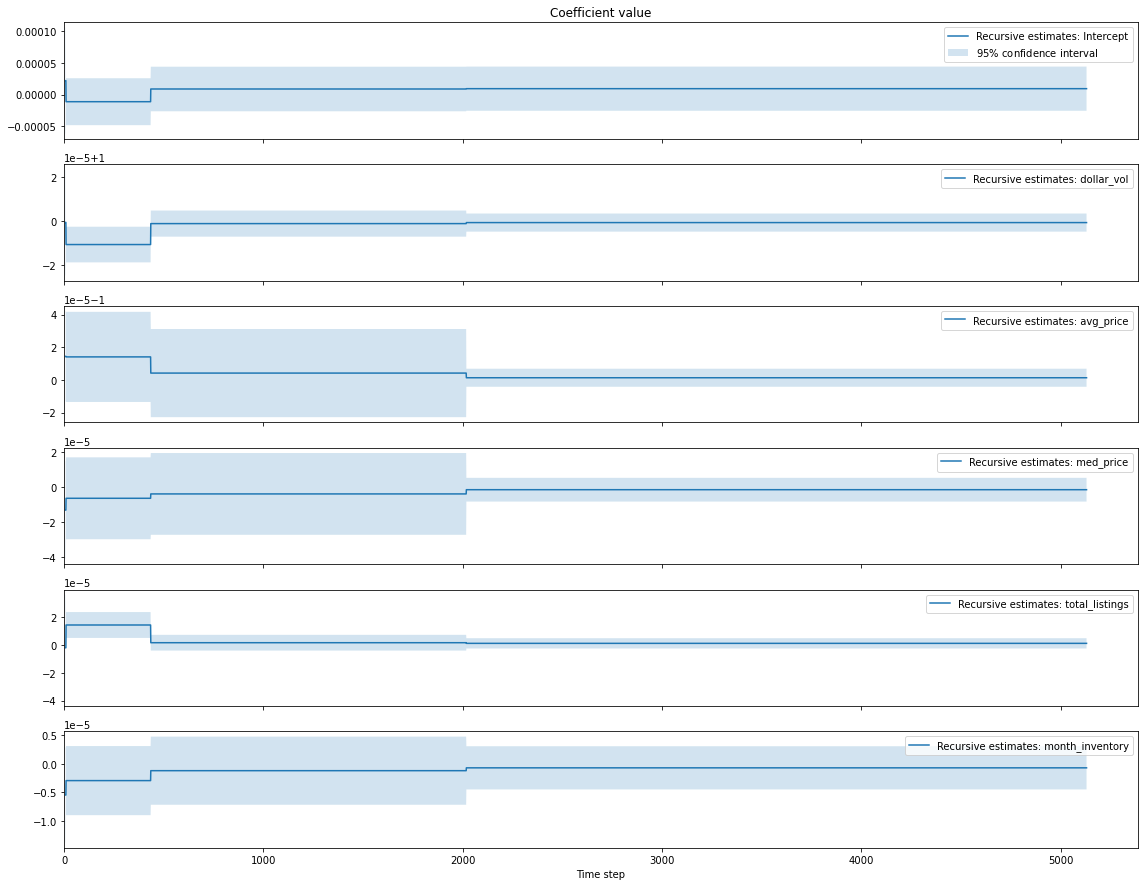

In [167]:
## Recursive ordinary least squares (expanding window rolling regression)
reg_rls = sm.RecursiveLS.from_formula(
    'sales ~ dollar_vol + avg_price + med_price + total_listings + month_inventory', df)
model_rls = reg_rls.fit()
#print(model_rls.summary())

fig = model_rls.plot_recursive_coefficient(range(reg_rls.k_exog), legend_loc='upper right')
ax_list = fig.axes
for ax in ax_list:
    ax.set_xlim(0, None)
ax_list[-1].set_xlabel('Time step')
ax_list[0].set_title('Coefficient value')

Next, we will be impleneting an **ARIMA model** for sales number prediction; the parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average. Set this to 12 to try & account for cyclical 12-month cycle of home prices

How do we decide these variables? This requires deeper exploration into 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4599
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8926.672
Method:                       css-mle   S.D. of innovations              1.685
Date:                Sat, 15 Jan 2022   AIC                          17867.345
Time:                        12:45:36   BIC                          17912.380
Sample:                             1   HQIC                         17883.196
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.007      0.065      0.948      -0.013       0.014
ar.L1.D.y     -0.8474      0.015    -58.252      0.000      -0.876      -0.819
ar.L2.D.y     -0.6804      0.018    -36.822      0.0

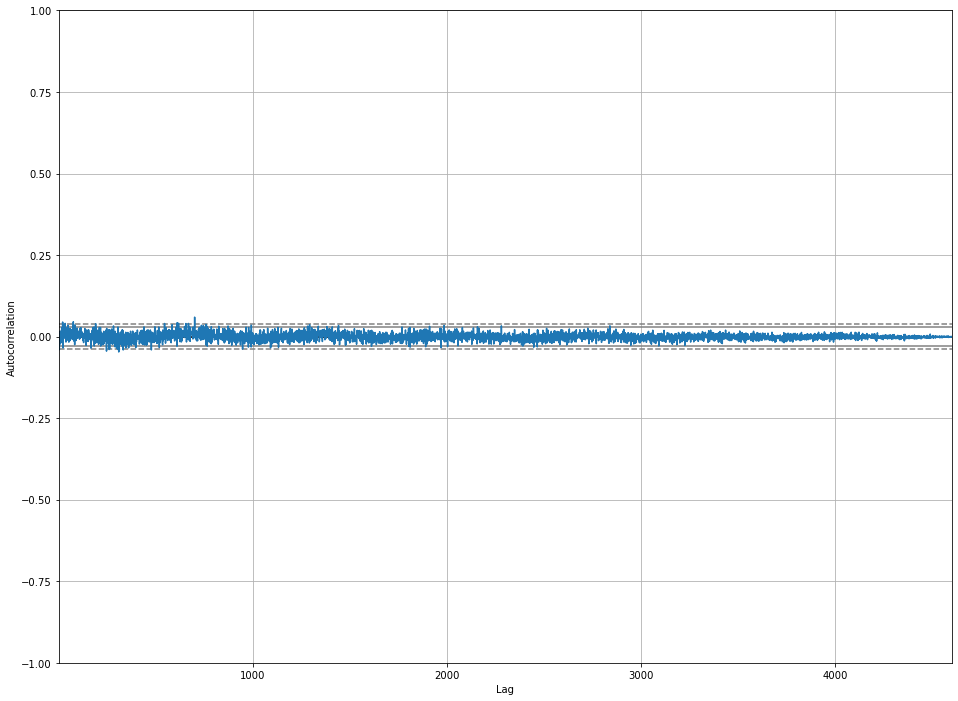

In [201]:
## ARIMA(Autoregressive Integrated Moving Average) implementation
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## making Time series
test = train[['date','sales']]
data = np.array(test['sales'])

## Creating Autocorrelation plot fpr sales & lag variable
x = pd.plotting.autocorrelation_plot(data)

model = ARIMA(data, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

**Generalized Additive Models**

If the data is having a nonlinear effect, in such a case we use GAM. Linearity in models means that the changes of one unit in predictors can cause the same effect on the outcome of the model. If at some point, changes in feature not affecting the outcome or impacting oppositely, we can say that there is a nonlinearity effect in the data.

For this section, we will explore the possibiltiy that the some of the relationships between our response & predictors follow a nonlinear relationship.


In [202]:
## Generalized Additive Models (GAM)
## Generalized Additive Models allow for penalized estimation of smooth terms in generalized linear models
from pygam import LinearGAM, s, f
from pandas.plotting import autocorrelation_plot

**On the utilziation of Neural Nets for Time Series Regression**

Our estimators here vary wildly in terms of weights - I suspect a variation of neural nets to be able to acqure better weight estiamtes for these coefficients

In [39]:
## basic NN with one covariate(avg_price)
horsepower = np.array(X_train['avg_price'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.summary()

#make predictions
horsepower_model.predict(horsepower[:10])

horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [40]:
history = horsepower_model.fit(
    X_train['avg_price'],
    X_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,4.426396,4.415226,95
96,4.426486,4.416012,96
97,4.426677,4.416144,97
98,4.426446,4.415113,98
99,4.426604,4.415454,99


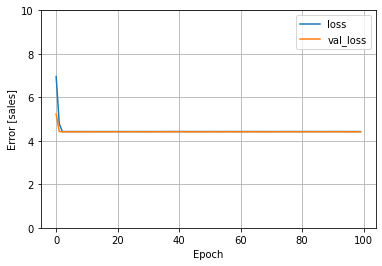

In [41]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [sales]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [43]:
## NN Linear Regression w/ Multiple Inputs
normalizer = tf.keras.layers.Normalization(axis=-1)

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(X_train[:10])

linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

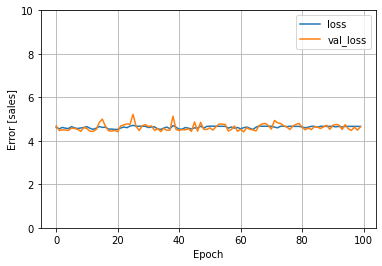

In [46]:
history = linear_model.fit(
    X_train['avg_price'],
    X_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

In [ ]:
## Deep Neural Net

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

  

In [ ]:
## Bayesian Neural Net

Comparison between Methods